In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Apply Yellow-White Mask
def yw_mask(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_yellow = np.array([20, 100, 100], dtype='uint8')
    upper_yellow = np.array([30, 255, 255], dtype='uint8')

    mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(img_gray, 125, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
    mask_yw_img = cv2.bitwise_and(img_gray, mask_yw)
    
    return mask_yw_img


# Add Gaussian Blur
def gauss_blur(mask_yw_img):
    return cv2.GaussianBlur(mask_yw_img, (5, 5), 0)


# Canny Edge Detection
def get_canny_edges(mask_yw_gauss):
    canny_edges = cv2.Canny(mask_yw_gauss, 5, 15)
    dilate = cv2.dilate(canny_edges, (5, 5), iterations=2)
    ero = cv2.erode(dilate, (5, 5), iterations=1)
    return ero


# Create and Apply ROI Mask
def apply_roi_mask(canny_edges):
    width, height = canny_edges.shape[1], canny_edges.shape[0]

    roi_mask = np.zeros_like(canny_edges)
    roi_corners = [np.array([
        [width/10, height],
        [width/2 - width/5, height/2 + height/5],
        [width/2 + width/5, height/2 + height/5],
        [width - width/10, height]
    ], dtype=np.int32)]

    cv2.fillPoly(roi_mask, roi_corners, 255)
    
    roi_canny = cv2.bitwise_and(canny_edges, roi_mask)
    return roi_canny


# Caches Previous Line
left_line = np.array([0, 0, 0, 0])
right_line = np.array([0, 0, 0, 0])

# Makes Line Using y=mx+b
def make_line_coordinates(img, slope, intercept):
    y1 = img.shape[0]
    y2 = int(y1 * 0.75)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    
    return np.array([x1, y1, x2, y2])


# Averages Left-Side and Right-Side Lanes
def avg_lines(img, lines):
    global left_line
    global right_line
    left = []
    right = []
    
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
        
        if abs(slope) > 0.5:    # Filters insignificant lines
            if slope < 0:
                left.append((slope, intercept))    # Negative slope = left lane
            else:
                right.append((slope, intercept))   # Positive slope = right lane

    
    if left:
        left_avg = np.average(left, axis=0)
        left_line = make_line_coordinates(img, left_avg[0], left_avg[1])
    
    if right:
        right_avg = np.average(right, axis=0)
        right_line = make_line_coordinates(img, right_avg[0], right_avg[1])
    
    
    return np.array([left_line, right_line])


# Hough Lines
def draw_hough_lines(img, roi_canny):
    #dotted_img = np.zeros_like(img)
    line_img = np.zeros_like(img)
    lines = cv2.HoughLinesP(roi_canny,
                            2,
                            np.pi/180,
                            100,
                            minLineLength=40,
                            maxLineGap=100)
    
    if np.any(lines):
        averaged_lines = avg_lines(img, lines)
    
        for line in averaged_lines:
            x1, y1, x2, y2 = line
            #cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 5)
            #cv2.circle(dotted_img, (x1, y1), 5, (0, 255, 0), 2)
        
        rect_corners = [np.array([[averaged_lines[0][0], averaged_lines[0][1]],
                                  [averaged_lines[1][0], averaged_lines[1][1]],
                                  [averaged_lines[1][2], averaged_lines[1][3]],
                                  [averaged_lines[0][2], averaged_lines[0][3]]
                                 ], dtype=np.int32)]
        cv2.fillPoly(line_img, rect_corners, (245, 165, 66))    # Fill lines

    
    final_img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    #dotted_img = cv2.addWeighted(img, 0.8, dotted_img, 1.0, 0.0)
    return final_img


# Auto Brightness and Contrast
def auto_adjustments(img, clip_hist_percent=25):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #gray = img
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    new_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return new_img

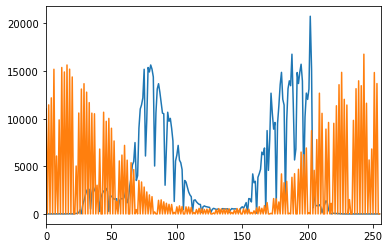

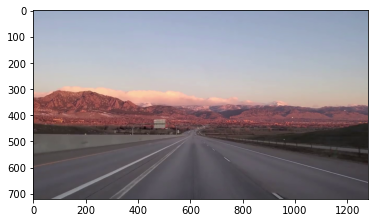

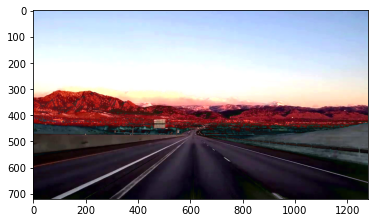

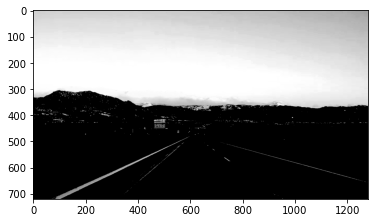

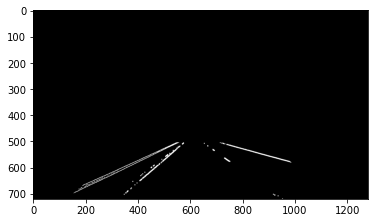

-1

In [4]:
cap = cv2.VideoCapture("dashcam_edited.mp4")

while True:
    success, frame = cap.read()
    if not success:
        break
    
    bright_frame = auto_adjustments(frame)
    
    mask_yw_img = yw_mask(bright_frame)
    mask_yw_gauss = gauss_blur(mask_yw_img)
    canny_edges = get_canny_edges(mask_yw_gauss)
    roi_canny = apply_roi_mask(canny_edges)
    final_frame = draw_hough_lines(frame, roi_canny)
    
    
    plt.figure()
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()
    
    plt.figure()
    plt.imshow(cv2.cvtColor(bright_frame, cv2.COLOR_BGR2RGB))
    plt.show()
    
    plt.figure()
    plt.imshow(mask_yw_img, cmap='gray')
    plt.show()
    
    plt.figure()
    plt.imshow(roi_canny, cmap='gray')
    plt.show()
    
    break
    
    cv2.imshow("Video", final_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cv2.waitKey(1)